In [1]:
# Import Libraries

import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi
import numpy as np

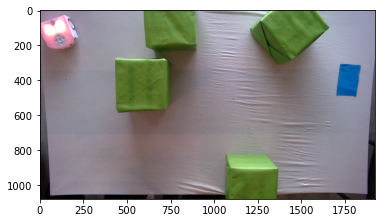

In [59]:
# New sample image:
img = cv2.imread('/Users/noah/Desktop/python/MobileRobotics/imageproc/image2.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_blur = cv2.bilateralFilter(img_rgb,9,75,75)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_hsv_blur = cv2.medianBlur(img_hsv, 15)
plt.imshow(img_rgb);

In [60]:
import cv2
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt


def f (hMin ,hMax ,Smin,Smax ,Vmin,Vmax):
    #img1 = img
    #img = cv2.cvtColor(img1 ,cv2.COLOR_BGR2RGB)  #in matplot image show in rgb format in cv2 it show in bgr format remeber this else you will face problem
    #hsv = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2HSV)# if you are going to use cv2 to show image then cv2.COLOR_BGR2HSV 
    hsv = img_hsv_blur
    Lhsv = np.array([hMin,Smin,Vmin])
    Uhsv = np.array([hMax ,Smax,Vmax])
    mask = cv2.inRange(hsv,Lhsv ,Uhsv)
    r = cv2.bitwise_and(img_rgb,img_rgb,mask =mask)
    
    
    plt.imshow(r)
  
    
interactive_plot = interactive(f,hMin=(0,179),hMax = (0,179),Smin = (0,250),Smax =(0,255),Vmin=(0,255),Vmax=(0,255))

In [62]:
interactive_plot

interactive(children=(IntSlider(value=118, description='hMin', max=179), IntSlider(value=179, description='hMa…

In [22]:
# UPDATED FUNCTIONS FOR COMPUTER VISION

In [246]:
def get_obstacle_position(img, thymio_radius, min_green = np.array([30, 87, 0]), max_green = np.array([90, 255, 255])):

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_green, max_green)
    mask = cv2.erode(mask, None, iterations=2) # 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)
    
    y_max, x_max = mask.shape

    # Expand obstacle size by the radius of the thymio
    dilatation_size = int(thymio_radius*1.2) # add security margin of 20% of thymio's radius
    kernel = cv2.getStructuringElement(cv.MORPH_RECT, (2 * dilatation_size + 1,2 * dilatation_size + 1))
    mask_dilated = cv2.dilate(mask, kernel, iterations = 1)

    contours = cv2.findContours(mask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2] # RETR_EXTERNAL to get external contour, CHAIN_APPROX_SIMPLE to get geometrical shape 

    output = cv2.bitwise_and(img, img, mask=mask)
    nb_obstacles = 0
    vertices = []
    if len(contours) != 0:
        contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
        for c in contours:
            area = cv.contourArea(c)
            #print(area)
            if area > 10000:
                nb_obstacles += 1
                epsilon = 0.015*cv.arcLength(c,True)
                approx = cv.approxPolyDP(c,epsilon,True)
                cv2.drawContours(output, [approx], -1, (0, 255, 255), 20)
                vertices.append(approx)
            else: 
                break

    plt.imshow(output);
    
    return (vertices, nb_obstacles, x_max, y_max)

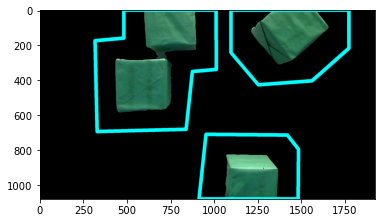

In [247]:
vertices, nb_obstacles, x_max, y_max = get_obstacle_position(img,98)

In [229]:
x_max

1920

In [230]:
y_max

1080

In [249]:
nb_obstacles

3

In [250]:
vertices

[array([[[ 480,    0]],
 
        [[ 480,  160]],
 
        [[ 315,  175]],
 
        [[ 327,  694]],
 
        [[ 837,  681]],
 
        [[ 873,  351]],
 
        [[1010,  339]],
 
        [[1009,    0]]], dtype=int32),
 array([[[1094,    0]],
 
        [[1094,  243]],
 
        [[1251,  427]],
 
        [[1559,  404]],
 
        [[1770,  218]],
 
        [[1770,    0]]], dtype=int32),
 array([[[ 951,  710]],
 
        [[ 911, 1079]],
 
        [[1479, 1079]],
 
        [[1481,  795]],
 
        [[1417,  714]]], dtype=int32)]

In [252]:
def get_thymio_position(img, kalman_center, kalman_angle, min_red = np.array([150, 0, 180]), max_red = np.array([179, 255, 255])):
    
    # RETURNS CENTER COORDINATES, RADIUS AND ORIENTATION (provides extra coordinants (xb, yb) to know which direction, as well as angle) OF THYMIO ROBOT

    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_red, max_red)
    mask = cv2.erode(mask, None, iterations=2) # 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)    
    output = cv2.bitwise_and(img, img, mask=mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
    
    #print(contours)
    #print(hierarchy)
    #cv2.drawContours(output ,[contours[0]],-1,(0,255,0),5)
    #cv2.drawContours(output ,[contours[1]],-1,(255,255,0),10)
    #cv2.drawContours(output ,[contours[2]],-1,(0,255,255),5)
    #plt.imshow(output)
    
    
    
    
    thymio_detected = False
    center = kalman_center
    radius = 0
    angle = kalman_angle
    
    if len(contours) != 0:

        # find the biggest countour c by the area
        c = max(contours, key = cv2.contourArea)
        if cv.contourArea(c) > 5000:
            thymio_detected = True
                    

            # Minimum Enclosing Circle :
            (x_circle,y_circle),radius = cv.minEnclosingCircle(c)
            center = (int(x_circle),int(y_circle))
            radius = int(radius)
            cv.circle(output,center,radius,(0,255,0),10) 

            for contour in contours:
                area = cv.contourArea(contour)
                if area > 2400 and area < 3200:
                    cv2.drawContours(output ,[contour],-1,(255,255,0),10)
                    (x_front,y_front),radius_front = cv.minEnclosingCircle(contour)
                    center_front = (int(x_front),int(y_front))
                    radius_front = int(radius_front)
                    cv.circle(output,center_front,radius_front,(255,255,0),10)
                    
                    angle = int(math.degrees(math.atan2(center_front[1]-center[1],center_front[0]-center[0]))) 
        
            
    plt.imshow(output)
        
    return center, radius, angle, thymio_detected

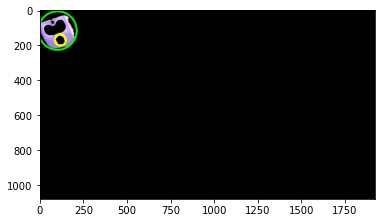

In [253]:
center, radius, angle, thymio_detected = get_thymio_position(img, (0,0), 0)

In [254]:
angle

73

In [255]:
def get_goal_position(img, min_blue = np.array([70, 80, 0]), max_blue = np.array([120, 255, 255])):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_blue, max_blue)
    mask = cv2.erode(mask, None, iterations=2) # 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)
    
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2] # RETR_EXTERNAL to get external contour, CHAIN_APPROX_SIMPLE to get geometrical shape 
    output = cv2.bitwise_and(img, img, mask=mask)
    
    x_center = 0
    y_center = 0
    goal_detected = False
    if len(contours) != 0:
        
        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        M = cv.moments(c)
        x_center = int(M['m10']/M['m00'])
        y_center = int(M['m01']/M['m00'])
        if cv2.contourArea(c) > 5000:
            goal_detected = True
            (x,y),radius = cv.minEnclosingCircle(c)
            center = (int(x),int(y))
            radius = int(radius)
            cv.circle(output,center,radius,(0,255,0),10) 
            
    plt.imshow(output)
          
        
    return x_center,y_center, goal_detected

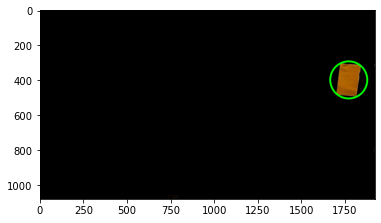

In [256]:
x_center,y_center, goal_detected = get_goal_position(img)

In [257]:
x_center

1767

In [258]:
y_center

398

In [259]:
goal_detected

True